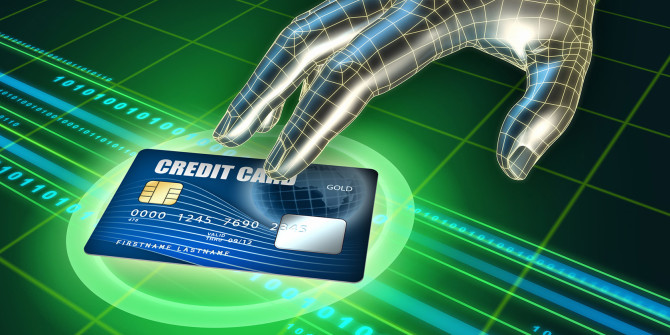

# **Import Libraries**

In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

sns.set_style('whitegrid') # sets the visual style of Seaborn plots to 'whitegrid', which displays a white background with grid lines.
sns.set_palette('pastel')  # sets the color palette to 'pastel', which is one of the predefined color palettes provided by Seaborn. It consists of a set of visually distinct colors suitable for plotting categorical data.

import warnings
# Ignore all warnings
warnings.simplefilter("ignore")

# **Load Data**

In [3]:
train_df = pd.read_csv('/content/fraudTest.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('/content/fraudTest.csv', index_col='Unnamed: 0')

# **Exploratory Data Analysis**

In [4]:
train_df.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-null  i

In [6]:
train_df.shape

(555719, 22)

In [7]:
is_fraud = train_df["is_fraud"].value_counts()
print("Yes: ",is_fraud[1])
print("No: ",is_fraud[0])

Yes:  2145
No:  553574


In [8]:
print(train_df.isna().sum().sum())
print(train_df.duplicated().sum())

0
0


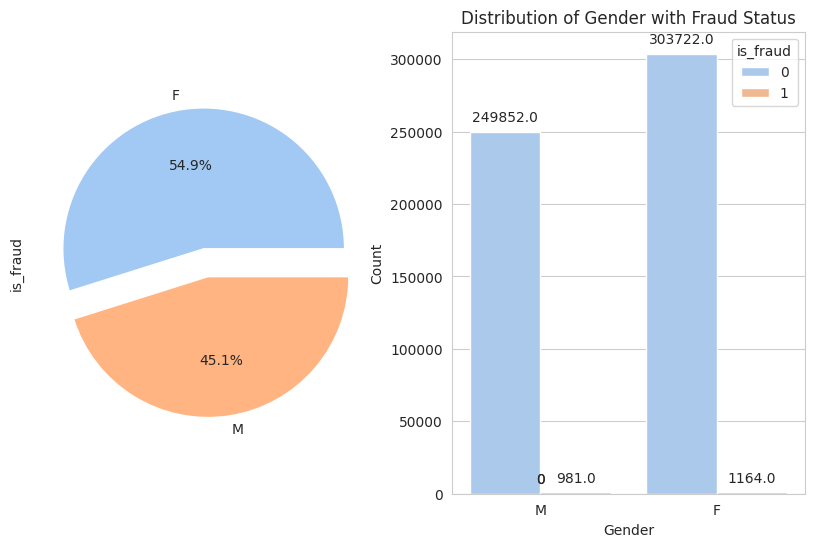

In [9]:
fig,axb = plt.subplots(ncols=2,nrows=1,figsize=(10, 6))

#Gender Distribution
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().plot.pie(explode=explode, autopct="%1.1f%%",ax=axb[0]);

ax = sns.countplot(x="gender", hue="is_fraud", data=train_df,ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.title("Distribution of Gender with Fraud Status")
plt.xlabel("Gender")
plt.ylabel("Count")

# Show the plot
plt.show()

Females are doing more transactions but males are more likely to make fraud transaction

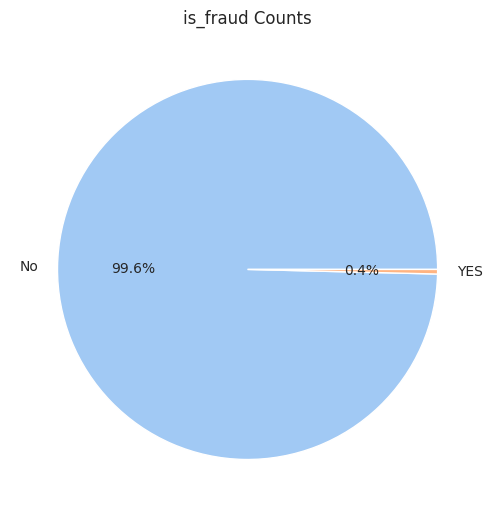

In [10]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(is_fraud, labels=["No", "YES"], autopct="%1.1f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

99.6% is not fraud and only 0.4% is fraud leads to imbalanced data

# **Feature Engineering**

In [11]:
#Change date type from obj to datetime
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'],format='mixed')
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'],format='mixed')

In [12]:
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,12,6
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,12,6
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,12,6
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,12,6
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,12,6


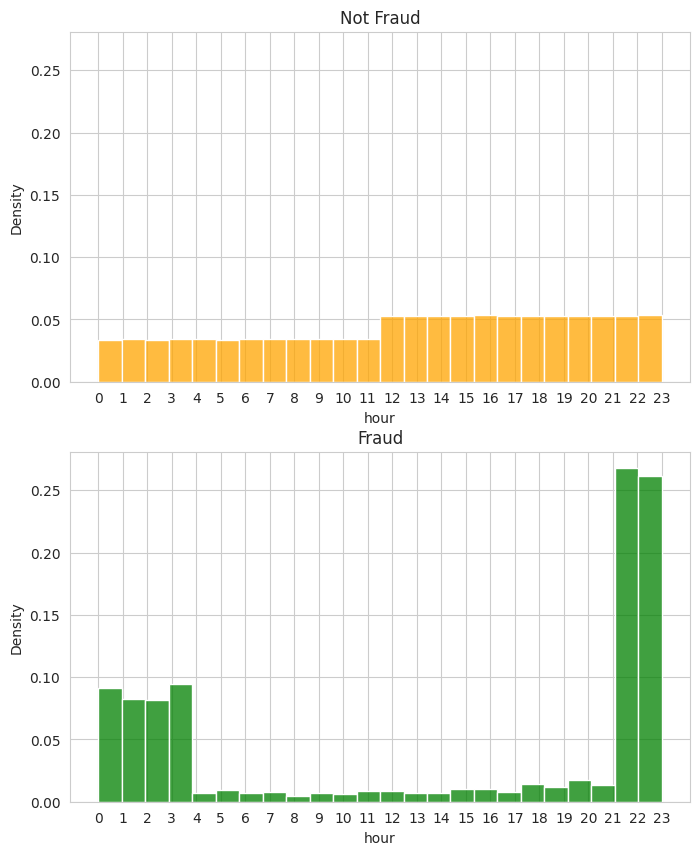

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), sharey=True)

ax1 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1, color="orange")

ax2 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="green")

ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

ax1.set_xticks(np.arange(24)) # ticks of the day 0 -> 23
ax2.set_xticks(np.arange(24));

It is clear that fraud transactions mainly occur at midnight.

last 2 hours of the day.

# **Data Pre-processing**

In [14]:
unique_transaction_count = len(train_df['trans_num'].unique())
print("Total count of unique transaction numbers:", unique_transaction_count)

Total count of unique transaction numbers: 555719


Concluding that each transaction has it's own number

In [15]:
# remove non-useful columns
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,fraud_Kirlin and Sons,personal_care,2.86,Elliott,M,33.9659,-80.9355,333497,Mechanical engineer,33.986391,-81.200714,0,12,6
1,fraud_Sporer-Keebler,personal_care,29.84,Williams,F,40.3207,-110.4360,302,"Sales professional, IT",39.450498,-109.960431,0,12,6


In [16]:
#clean merchant column
train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   merchant    555719 non-null  object 
 1   category    555719 non-null  object 
 2   amt         555719 non-null  float64
 3   last        555719 non-null  object 
 4   gender      555719 non-null  object 
 5   lat         555719 non-null  float64
 6   long        555719 non-null  float64
 7   city_pop    555719 non-null  int64  
 8   job         555719 non-null  object 
 9   merch_lat   555719 non-null  float64
 10  merch_long  555719 non-null  float64
 11  is_fraud    555719 non-null  int64  
 12  hour        555719 non-null  int32  
 13  month       555719 non-null  int32  
dtypes: float64(5), int32(2), int64(2), object(5)
memory usage: 59.4+ MB


In [18]:
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,Kirlin and Sons,personal_care,2.86,Elliott,M,33.9659,-80.9355,333497,Mechanical engineer,33.986391,-81.200714,0,12,6
1,Sporer-Keebler,personal_care,29.84,Williams,F,40.3207,-110.4360,302,"Sales professional, IT",39.450498,-109.960431,0,12,6


In [19]:
train_df.describe(include='object')

,merchant,category,last,gender,job
count,555719,555719,555719,555719,555719
unique,693,14,471,2,478
top,Kilback LLC,gas_transport,Smith,F,Film/video editor
freq,1859,56370,12146,304886,4119


# **Data Encoding**

**WOEEncoder**
is a type of categorical encoding technique used in machine learning, particularly in the context of handling categorical variables in predictive modeling tasks, such as classification. WOE stands for "Weight of Evidence." It's a popular encoding technique in credit scoring and fraud detection.

In summary, while label encoding simply assigns numerical labels to categories, WOE encoding calculates numerical values based on the relationship between each category and the target variable, providing more meaningful representations for categorical variables in certain modeling contexts, especially those where the predictive power of categorical variables is crucial.

In [20]:
# applying label encoding
train_df['gender'] = train_df['gender'].map({'F': 0, 'M': 1})

# applying WOE encoding
for col in ['job','merchant', 'category', 'lat', 'last']:
    train_df[col] = WOEEncoder().fit_transform(train_df[col],train_df['is_fraud'])

In [21]:
train_df.head(3)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,0.340113,-0.762903,2.86,-1.611619,1,33.9659,-80.9355,333497,-2.243730,33.986391,-81.200714,0,12,6
1,-0.420209,-0.762903,29.84,0.620054,0,40.3207,-110.4360,302,-2.286016,39.450498,-109.960431,0,12,6
2,-0.381243,-0.985812,41.28,-2.124146,0,40.6729,-73.5365,34496,0.472088,40.495810,-74.196111,0,12,6


# **Down-Sampling and Scaling**

as our data is imbalanced we will use Resampling Techniques

**down_sampling technique :**

Downsampling involves reducing the number of instances in the majority class to balance it with the number of instances in the minority class.

This helps prevent the machine learning model from being biased towards the majority class and improves its ability to learn patterns from the minority class.

In [22]:
!pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # Import StandardScaler
from sklearn.utils import resample

In [23]:
No_class = train_df[train_df["is_fraud"]==0]
yes_class = train_df[train_df["is_fraud"]==1]

No_class = resample(No_class, replace=False, n_samples=len(yes_class))
down_samples = pd.concat([yes_class, No_class], axis=0)


X = down_samples.drop("is_fraud", axis=1)
y = down_samples["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

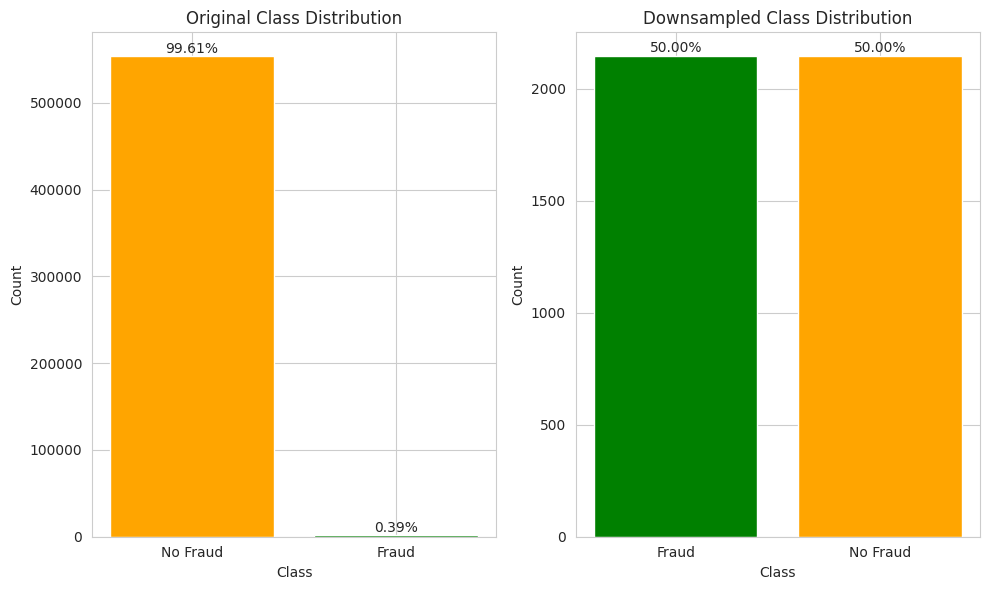

In [24]:
# Count the occurrences of each class in the original dataset
original_class_counts = train_df["is_fraud"].value_counts()

# Count the occurrences of each class in the downsampled dataset
downsampled_class_counts = down_samples["is_fraud"].value_counts()

# Calculate the percentage of each class
original_percentages = original_class_counts / len(train_df) * 100
downsampled_percentages = downsampled_class_counts / len(down_samples) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Bar chart for original class distribution
plt.subplot(1, 2, 1)
bars_1 = plt.bar(original_class_counts.index, original_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_1, original_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(original_class_counts.index, ['No Fraud', 'Fraud'])

# Bar chart for downsampled class distribution
plt.subplot(1, 2, 2)
bars_2 = plt.bar(downsampled_class_counts.index, downsampled_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_2, downsampled_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Downsampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(downsampled_class_counts.index, ['No Fraud', 'Fraud'])

plt.tight_layout() # the plots will be automatically adjusted to ensure that there is no overlap between subplots and that all elements are clearly visible.
plt.show()


# **Machine Learning model training**

### **GaussianNB**

In [25]:
# Create and train the Gaussian Naive Bayes model
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_naive = NB_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_naive))
GaussianNB_accuracy = accuracy_score(y_pred_naive, y_test)
print('Naive Bayes model accuracy is: {:.2f}%'.format(GaussianNB_accuracy * 100))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       426
           1       0.90      0.80      0.85       432

    accuracy                           0.85       858
   macro avg       0.86      0.85      0.85       858
weighted avg       0.86      0.85      0.85       858

Naive Bayes model accuracy is: 85.43%


### **Decision Tree Model (ID3)**

In [26]:
DT = DecisionTreeClassifier(max_depth=(1), random_state=0)
DT.fit(X_train, y_train)
predict_ID3 = DT.predict(X_test)
print(classification_report(y_test, predict_ID3))
ID3_accuracy = accuracy_score(predict_ID3,y_test)
print('ID3 model accuracy is: {:.2f}%'.format(ID3_accuracy*100))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       426
           1       0.96      0.75      0.84       432

    accuracy                           0.86       858
   macro avg       0.87      0.86      0.85       858
weighted avg       0.87      0.86      0.85       858

ID3 model accuracy is: 85.55%


### **Support Vector Machine Model (SVC)**

In [27]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
predict = svm_model.predict(X_test)

print(classification_report(y_test, predict))
svm_accuracy = accuracy_score(predict,y_test)
print('SVC model accuracy is: {:.2f}%'.format(svm_accuracy*100))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       426
           1       0.88      0.90      0.89       432

    accuracy                           0.89       858
   macro avg       0.89      0.89      0.89       858
weighted avg       0.89      0.89      0.89       858

SVC model accuracy is: 88.93%


  ### **Logistic Regression -> LR**

In [28]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
predict_LR = LR_model.predict(X_test)
print(classification_report(y_test, predict_LR))
LR_accuracy = accuracy_score(predict_LR,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_accuracy*100))


              precision    recall  f1-score   support

           0       0.90      0.88      0.89       426
           1       0.88      0.90      0.89       432

    accuracy                           0.89       858
   macro avg       0.89      0.89      0.89       858
weighted avg       0.89      0.89      0.89       858

Logistic Regression accuracy is: 88.93%


### **RandomForestClassifier**

In [29]:
# Initialize and train the Random Forest classifier
RF = RandomForestClassifier(n_estimators=100, random_state=0)
RF.fit(X_train, y_train)

predict_RF = RF.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predict_RF))
RF_accuracy = accuracy_score(predict_RF, y_test)
print('Random Forest model accuracy is: {:.2f}%'.format(RF_accuracy * 100))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       426
           1       0.98      0.97      0.98       432

    accuracy                           0.98       858
   macro avg       0.98      0.98      0.98       858
weighted avg       0.98      0.98      0.98       858

Random Forest model accuracy is: 97.55%


### **XGBClassifier**

In [30]:
# Initialize and train the XGBoost classifier
XGB = XGBClassifier(random_state=0)
XGB.fit(X_train, y_train)

# Make predictions on the test set
predict_XGB = XGB.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predict_XGB))
XGB_accuracy = accuracy_score(predict_XGB, y_test)
print('XGBoost model accuracy is: {:.2f}%'.format(XGB_accuracy * 100))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       426
           1       0.98      0.97      0.98       432

    accuracy                           0.98       858
   macro avg       0.98      0.98      0.98       858
weighted avg       0.98      0.98      0.98       858

XGBoost model accuracy is: 97.79%


# **Final Result**

In [31]:
Algorithms = ['GaussianNB', 'ID3', 'SVC', 'Logistic Regression', 'RandomForest','XGBClassifier']
accuracy = [GaussianNB_accuracy, ID3_accuracy, svm_accuracy, LR_accuracy, RF_accuracy, XGB_accuracy,   ]

FinalResult=pd.DataFrame({'Algorithm':Algorithms, 'Accuracy':accuracy})

FinalResult


,Algorithm,Accuracy
0,GaussianNB,0.854312
1,ID3,0.855478
2,SVC,0.889277
3,Logistic Regression,0.889277
4,RandomForest,0.975524
5,XGBClassifier,0.977855


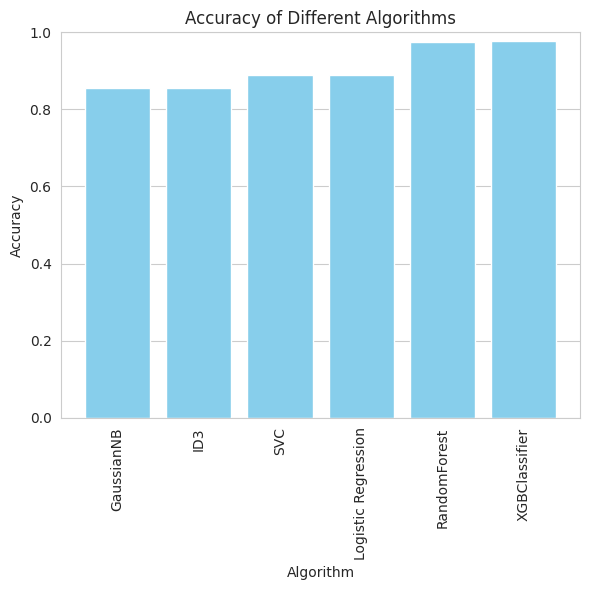

In [32]:
plt.figure(figsize=(6, 6))
plt.bar(FinalResult['Algorithm'], FinalResult['Accuracy'], color="skyblue")
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Algorithms')
plt.ylim(0, 1)  # Set the limit of y-axis from 0 to 1 (accuracy ranges from 0 to 1)
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.grid(axis='x')  # Add gridlines only along the x-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Among those five classifier the best accuracy we get by the **XGBClassifier**.